# Social graphs and interactions final assingment
Social graphs and interactions (02805) - DTU

Authors:

- Fernando Augusto Marina Urriola - s233144@dtu.dk
- Juan Jose Martinez Mañas - s240451@dtu.dk
- Jesus Diaz de Pereira - s233142@dtu.dk


## Problem statement & motivation

- **Problem Statement**: The Danish startup ecosystem, renowned for its innovation and progressive policies, has seen significant growth in recent years, but the complex interactions within this network remain underexplored. Despite efforts to foster connections among startups, investors, and accelerators, limited data is available on how these entities influence each other in terms of resources, industry focus, and market influence. As the Danish ecosystem matures, understanding its internal dynamics becomes essential for policymakers, investors, and entrepreneurs aiming to strengthen its structure and global impact.

- **Motivation**: By mapping the Danish startup network through graph-based analysis, we can reveal clusters, hubs, and key pathways that drive growth and collaboration. This research will provide insights into which industries are most interconnected, identify potential synergies, and shed light on underrepresented areas within the ecosystem. This study ultimately aims to enhance transparency and guide resource allocation, paving the way for a more resilient and collaborative Danish startup landscape.

## Code

In this section all the code for the project it's been developed and showed.

##### Imports

In [1]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install vaderSentiment
!pip install newspaper3k requests
!pip install lxml_html_clean
!pip install python-louvain
!pip install wordcloud



import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 25.8 MB/s eta 0:00:00
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,458 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,331 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-driver

In [2]:
import random
import time
import pandas as pd
import nltk
import re
import requests


from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from selenium.common.exceptions import TimeoutException

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import community
import community.community_louvain as community_louvain
from itertools import combinations
from collections import Counter

from newspaper import Article
from lxml_html_clean import clean_html


import matplotlib.patches as mpatches
import networkx as nx


### Data mining & data cleaning

Data extracted from:https://www.eu-startups.com/directory/

Specifically: https://www.eu-startups.com/directory/wpbdp_category/danish-startups/


##### Data mining- Web scrapping with Selenium and BeautifulSoup
- Selenium: This is a tool primarily used for automating web browsers, allowing interaction with web pages by simulating user actions (e.g., clicks, typing). It's helpful for scraping dynamic websites where JavaScript content needs to load before scraping.

- Beautiful Soup: A Python library used to parse HTML and XML documents. It allows for easy extraction of specific parts of a web page, like text and links, by providing tools to search through and parse the page structure.

Further down, it can be seen the web scrapper developed by the team.
It is important to note that, by inspectioning the web page, the team was able to scrap al the data from each company.

In [ ]:
# Set up WebDriver
driver = webdriver.Chrome()  # Ensure you have ChromeDriver set up in PATH
wait = WebDriverWait(driver, 10)

# Base URL then we will iterate through the pages
base_url = "https://www.eu-startups.com/directory/wpbdp_category/danish-startups/page/"
results = []

# Loop through the pages
for page_num in range(1, 60):
    url = f"{base_url}{page_num}/"
    print(f"Scraping page {page_num}")

    driver.get(url)

    # Wait until the listings are loaded
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "div.wpbdp-listing")))

    # Get the page source and parse it with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Find all listings on the current page
    listings = soup.select('div.wpbdp-listing')

    # Loop through each listing
    for listing in listings:
        try:
            # Find the link to the detailed page for each company
            company_link = listing.select_one("div.listing-title h3 a")
            company_name = company_link.text.strip()
            company_url = company_link['href']

            # Open the company's detailed page
            driver.get(company_url)
            time.sleep(2)  # Add a slight delay to allow page load

            # Parse the company's detailed page
            detailed_soup = BeautifulSoup(driver.page_source, 'html.parser')

            # Extract fields from the detailed page
            category = detailed_soup.select_one("div.wpbdp-field-display span:contains('Category:') + div.value").text.strip() if detailed_soup.select_one("div.wpbdp-field-display span:contains('Category:') + div.value") else ''
            description = detailed_soup.select_one("div.wpbdp-field-display span:contains('Business Description:') + div.value").text.strip() if detailed_soup.select_one("div.wpbdp-field-display span:contains('Business Description:') + div.value") else ''
            long_description = detailed_soup.select_one("div.wpbdp-field-display span:contains('Long Business Description:') + div.value").text.strip() if detailed_soup.select_one("div.wpbdp-field-display span:contains('Long Business Description:') + div.value") else ''
            based_in = detailed_soup.select_one("div.wpbdp-field-display span:contains('Based in:') + div.value").text.strip() if detailed_soup.select_one("div.wpbdp-field-display span:contains('Based in:') + div.value") else ''
            tags = detailed_soup.select_one("div.wpbdp-field-display span:contains('Tags:') + div.value").text.strip() if detailed_soup.select_one("div.wpbdp-field-display span:contains('Tags:') + div.value") else ''
            total_funding = detailed_soup.select_one("div.wpbdp-field-display span:contains('Total Funding:') + div.value").text.strip() if detailed_soup.select_one("div.wpbdp-field-display span:contains('Total Funding:') + div.value") else ''
            founded = detailed_soup.select_one("div.wpbdp-field-display span:contains('Founded:') + div.value").text.strip() if detailed_soup.select_one("div.wpbdp-field-display span:contains('Founded:') + div.value") else ''
            website = detailed_soup.select_one("div.wpbdp-field-display span:contains('Website:') + div.value").text.strip() if detailed_soup.select_one("div.wpbdp-field-display span:contains('Website:') + div.value") else ''
            company_status = detailed_soup.select_one("div.wpbdp-field-display span:contains('Company Status:') + div.value").text.strip() if detailed_soup.select_one("div.wpbdp-field-display span:contains('Company Status:') + div.value") else ''

            # Append data to results
            results.append({
                'Name': company_name,
                'Category': category,
                'Business Description': description,
                'Long Business Description': long_description,
                'Based in': based_in,
                'Tags': tags,
                'Total Funding': total_funding,
                'Founded': founded,
                'Website': website,
                'Company Status': company_status
            })

            # Return to the listings page
            driver.back()
            time.sleep(2)  # Slight delay to allow page reload

        except Exception as e:
            print(f"Error processing listing: {e}")
            continue

    # Optional sleep between pages to avoid overwhelming the server
    time.sleep(1)

# Close the browser
driver.quit()

# Save data to csv
df = pd.DataFrame(results)
df.to_csv("detailed_danish_startups_correct.csv", index=False)
print(df.to_string(index=False))


#### Data cleaning

In this section, the data cleaning of the dataset it's performed.

Overview of the dataset:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/SocialGraphsData/danish_startups.csv")
df

,Unnamed: 0,Name,Category,Business Description,Based in,Tags,Total Funding,Founded,Website,Company Status
0,0,Print Pronto,Denmark,Print Pronto is a premier print marketplace th...,"USA (17 Main St. Suite 302-C Robbinsville, NJ ...","CustomPrinting,PrintMarketplace",Between €100K-€500K,2023.0,https://printpronto.com/,Active
1,1,Ocean.io,Denmark,Ocean is the Revenue Intelligence Platform usi...,Copenhagen,SaaS,Between €5 million-€10 million,2017.0,https://ocean.io/,NaN
2,2,Fluentos,Denmark,Fluentos empowers e-commerce businesses to inc...,Vejle,"E-Commerce, Marketing Platform, Popup, SaaS, B...",No funding announced yet,2022.0,https://fluentos.com,NaN
3,6,EagleHunt AI,Denmark,EagleHunt.AI provides an AI-driven Visual Stud...,Holbek,"CodeSecurity,AIIntegration,VisualStudioCode",Between €100K-€500K,2024.0,https://eaglehunt.ai,Active
4,7,Machina Sports,Denmark,Machina Sports is a pioneering sports technolo...,Holbek,"SportsTech,AI,RealTimeData",Between €1-€100K,2023.0,https://machina.gg/,Active
...,...,...,...,...,...,...,...,...,...,...
354,598,Muninn,Denmark,Muninn is AI technology that empower companies...,Copenhagen,"Cyber Security, AI, Machine-learning, Software",Between €2.5 million-5 million,2016.0,https://www.muninn.ai,NaN
355,617,BotXO,Denmark,"BotXO develops conversational AI, bots, and au...",Copenhagen,"Artificial Intelligence, Machine Learning, Per...",Between €2.5 million-5 million,2016.0,http://www.botxo.ai,NaN
356,618,Nordetect,Denmark,Copenhagen-based Nordetect is an analytical ha...,Copenhagen,"AgTech, Analytics, Hardware, Internet of Things",Between €1 million-€ 2.5 million,2016.0,https://nordetect.com,NaN
357,642,Grant Compass,Denmark,Our purpose is to help philanthropic foundatio...,"Copenhagen, Hovedstaden","Information Technology, Software",Above €25 million,2016.0,https://grantcompass.com/,NaN


In [6]:
df = df.drop(['Unnamed: 0'], axis=1)

In [7]:
df.columns

Index(['Name', 'Category', 'Business Description', 'Based in', 'Tags',
       'Total Funding', 'Founded', 'Website', 'Company Status'],
      dtype='object')

As it can be seen, there are some NaN values in different companies.
NLP could be used in columns like: *Business Description* and *Longer Business Description*. Valuable information could be extracted from those columns. For example, extracting the category from the business description, among other ideas.

In [8]:
df = df.drop_duplicates(subset='Name', keep='first')
df

,Name,Category,Business Description,Based in,Tags,Total Funding,Founded,Website,Company Status
0,Print Pronto,Denmark,Print Pronto is a premier print marketplace th...,"USA (17 Main St. Suite 302-C Robbinsville, NJ ...","CustomPrinting,PrintMarketplace",Between €100K-€500K,2023.0,https://printpronto.com/,Active
1,Ocean.io,Denmark,Ocean is the Revenue Intelligence Platform usi...,Copenhagen,SaaS,Between €5 million-€10 million,2017.0,https://ocean.io/,NaN
2,Fluentos,Denmark,Fluentos empowers e-commerce businesses to inc...,Vejle,"E-Commerce, Marketing Platform, Popup, SaaS, B...",No funding announced yet,2022.0,https://fluentos.com,NaN
3,EagleHunt AI,Denmark,EagleHunt.AI provides an AI-driven Visual Stud...,Holbek,"CodeSecurity,AIIntegration,VisualStudioCode",Between €100K-€500K,2024.0,https://eaglehunt.ai,Active
4,Machina Sports,Denmark,Machina Sports is a pioneering sports technolo...,Holbek,"SportsTech,AI,RealTimeData",Between €1-€100K,2023.0,https://machina.gg/,Active
...,...,...,...,...,...,...,...,...,...
354,Muninn,Denmark,Muninn is AI technology that empower companies...,Copenhagen,"Cyber Security, AI, Machine-learning, Software",Between €2.5 million-5 million,2016.0,https://www.muninn.ai,NaN
355,BotXO,Denmark,"BotXO develops conversational AI, bots, and au...",Copenhagen,"Artificial Intelligence, Machine Learning, Per...",Between €2.5 million-5 million,2016.0,http://www.botxo.ai,NaN
356,Nordetect,Denmark,Copenhagen-based Nordetect is an analytical ha...,Copenhagen,"AgTech, Analytics, Hardware, Internet of Things",Between €1 million-€ 2.5 million,2016.0,https://nordetect.com,NaN
357,Grant Compass,Denmark,Our purpose is to help philanthropic foundatio...,"Copenhagen, Hovedstaden","Information Technology, Software",Above €25 million,2016.0,https://grantcompass.com/,NaN


In [9]:
df = df.dropna(subset=['Category'])
df

,Name,Category,Business Description,Based in,Tags,Total Funding,Founded,Website,Company Status
0,Print Pronto,Denmark,Print Pronto is a premier print marketplace th...,"USA (17 Main St. Suite 302-C Robbinsville, NJ ...","CustomPrinting,PrintMarketplace",Between €100K-€500K,2023.0,https://printpronto.com/,Active
1,Ocean.io,Denmark,Ocean is the Revenue Intelligence Platform usi...,Copenhagen,SaaS,Between €5 million-€10 million,2017.0,https://ocean.io/,NaN
2,Fluentos,Denmark,Fluentos empowers e-commerce businesses to inc...,Vejle,"E-Commerce, Marketing Platform, Popup, SaaS, B...",No funding announced yet,2022.0,https://fluentos.com,NaN
3,EagleHunt AI,Denmark,EagleHunt.AI provides an AI-driven Visual Stud...,Holbek,"CodeSecurity,AIIntegration,VisualStudioCode",Between €100K-€500K,2024.0,https://eaglehunt.ai,Active
4,Machina Sports,Denmark,Machina Sports is a pioneering sports technolo...,Holbek,"SportsTech,AI,RealTimeData",Between €1-€100K,2023.0,https://machina.gg/,Active
...,...,...,...,...,...,...,...,...,...
354,Muninn,Denmark,Muninn is AI technology that empower companies...,Copenhagen,"Cyber Security, AI, Machine-learning, Software",Between €2.5 million-5 million,2016.0,https://www.muninn.ai,NaN
355,BotXO,Denmark,"BotXO develops conversational AI, bots, and au...",Copenhagen,"Artificial Intelligence, Machine Learning, Per...",Between €2.5 million-5 million,2016.0,http://www.botxo.ai,NaN
356,Nordetect,Denmark,Copenhagen-based Nordetect is an analytical ha...,Copenhagen,"AgTech, Analytics, Hardware, Internet of Things",Between €1 million-€ 2.5 million,2016.0,https://nordetect.com,NaN
357,Grant Compass,Denmark,Our purpose is to help philanthropic foundatio...,"Copenhagen, Hovedstaden","Information Technology, Software",Above €25 million,2016.0,https://grantcompass.com/,NaN


The dataset now does not contain duplicates and is ready for data cleaning.

There are 359 startups, let's have a look to the data

### EDA

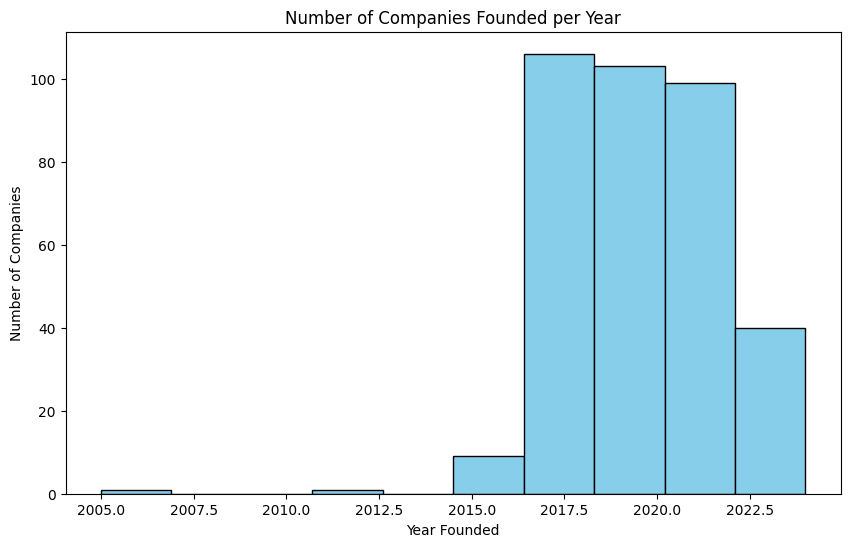

In [10]:
# Number of Companies Founded per Year

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['Founded'], bins=10, edgecolor='black',color="skyblue")
plt.title('Number of Companies Founded per Year')
plt.xlabel('Year Founded')
_ = plt.ylabel('Number of Companies')

From 2017 and onwards it was the period when most companies on the dataset where founded.

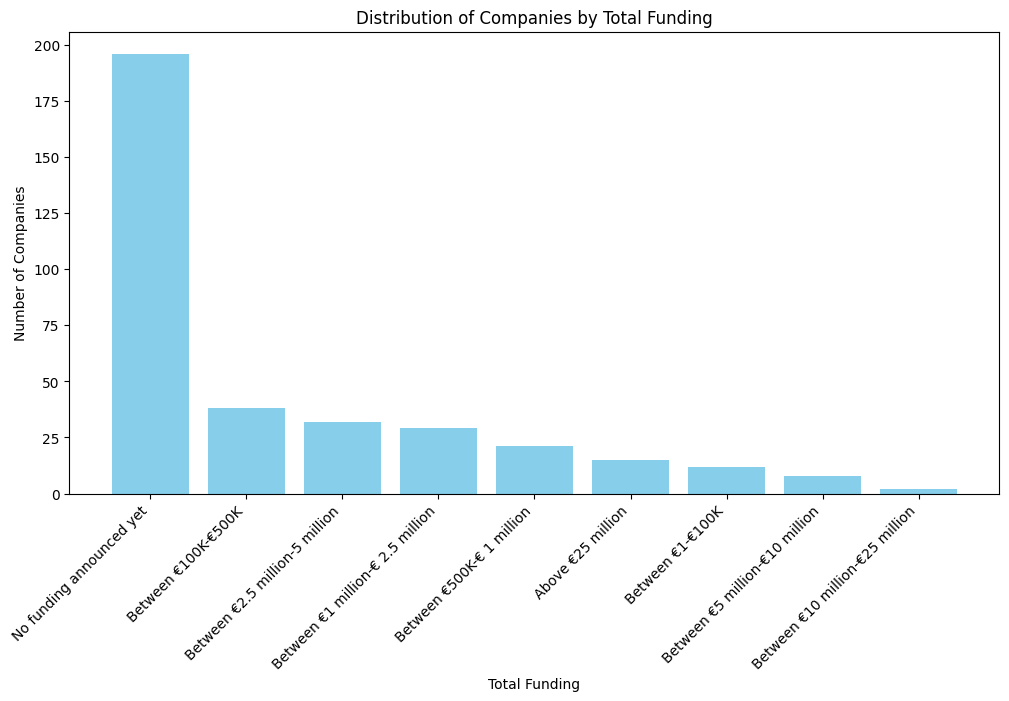

In [11]:
# Distribution of Companies by Total Funding

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
funding_counts = df['Total Funding'].value_counts()
plt.bar(funding_counts.index, funding_counts.values,color="skyblue")
plt.title('Distribution of Companies by Total Funding')
plt.xlabel('Total Funding')
plt.ylabel('Number of Companies')
_ = plt.xticks(rotation=45, ha='right')

It can bee seen that there are startups with a high funding...

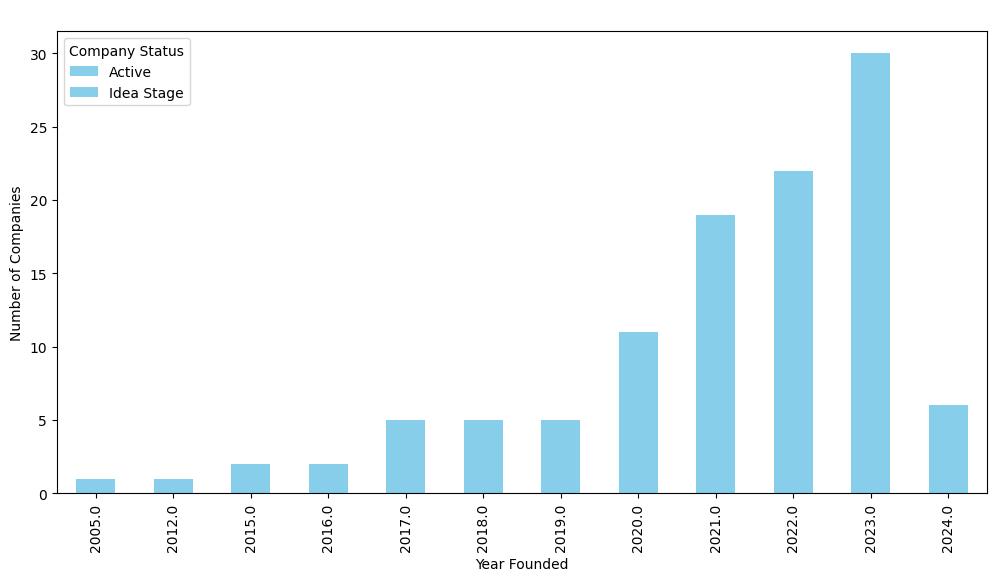

In [12]:
# Company Status by Founding Year

import matplotlib.pyplot as plt

company_status_by_year = df.groupby(['Founded', 'Company Status'])['Name'].count().unstack()

company_status_by_year.plot(kind='bar', stacked=True, figsize=(12, 6),color='skyblue')
plt.xlabel('Year Founded')
plt.ylabel('Number of Companies')
plt.title(' ')
_ = plt.legend(title='Company Status')

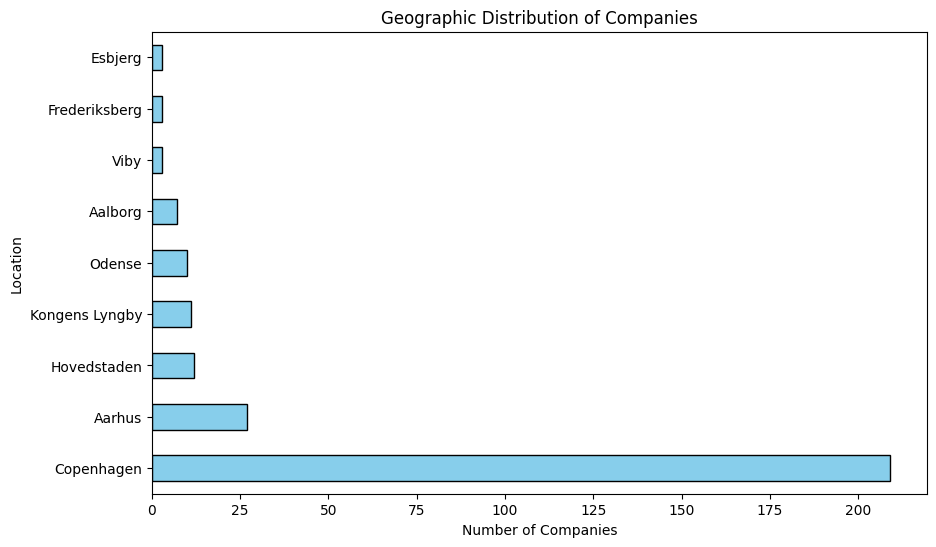

In [13]:
# Geographic Distribution of Companies

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df['Based in'].value_counts().head(9).plot(kind='barh', edgecolor='black',color="skyblue")
plt.title('Geographic Distribution of Companies')
plt.xlabel('Number of Companies')
_ = plt.ylabel('Location')

### Natural Language Processing - First iteration

> Why use NLP?

> One of the columns in the dataset is the *Business Description* of the company therefore, valuable information could be also extracted.

> The main reason of using NLP before doing the graph analysis is to understand in depth more the information contained in **Business Description** therefore, making better decisions when it comes to develop the graph.



##### Word count
The purpose is to identify common words or phrases in startup descriptions to understand common themes or trends.

In [14]:
# Preprocess and tokenize the text in "Business Description"
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation and non-alphabetical characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return words

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

import os
punkt_path = "/root/nltk_data/tokenizers/punkt"
print(os.listdir(punkt_path))
import nltk
nltk.data.path.append('/root/nltk_data')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['swedish.pickle', 'russian.pickle', 'malayalam.pickle', 'czech.pickle', 'spanish.pickle', '.DS_Store', 'PY3', 'slovene.pickle', 'portuguese.pickle', 'italian.pickle', 'README', 'estonian.pickle', 'danish.pickle', 'turkish.pickle', 'dutch.pickle', 'greek.pickle', 'finnish.pickle', 'french.pickle', 'german.pickle', 'english.pickle', 'norwegian.pickle', 'polish.pickle']


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [15]:
# Apply preprocessing to  "Business Description" column and flatten the list of words
all_words = [word for description in df['Business Description'].dropna() for word in preprocess_text(description)]

# Calculate word frequencies
word_counts = Counter(all_words)

# Display the most common words
print("Most common words:")
for word, freq in word_counts.most_common(10):
    print(f"{word}: {freq}")

Most common words:
platform: 98
data: 91
company: 88
companies: 72
business: 62
help: 59
new: 57
make: 56
solutions: 53
products: 53


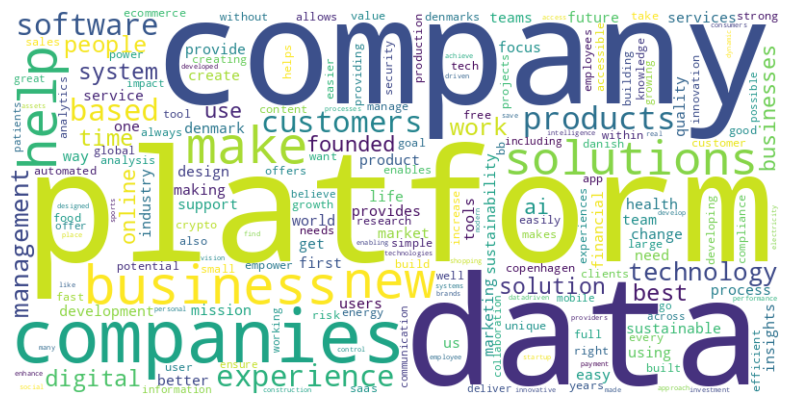

In [16]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

As it can be seen in the graphic, startups frequently emphasize terms like "platform," "data," "company," and "solutions," indicating a strong focus on technology-driven platforms and data-centric solutions. Terms such as "business," "help," and "customers" suggest a customer-oriented approach, with companies aiming to "make" or improve processes.

This highlights a trend towards technology-based services designed to enhance business efficiency and customer experience.

#####  Topic Modeling
 Discover hidden topics or themes in the descriptions. Latent Dirichlet Allocation (LDA) to uncover hidden topics within the business descriptions and compare the results with the Tags column to assess how well the topics align with the existing tags.

In [17]:
# Preprocess the text in the "Business Description" column
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

In [18]:
# Apply preprocessing
df['processed_description'] = df['Business Description'].fillna('').apply(preprocess_text)

# Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['processed_description'])

# Define the number of topics
num_topics = 5

# Apply LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(X)

# Display the top words in each topic
words = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Topic {i+1}:")
    print(" ".join([words[i] for i in topic.argsort()[-5:]]))

# Compare hidden topics with Tags
df['topic'] = lda.transform(X).argmax(axis=1)
topic_tags_comparison = pd.crosstab(df['Tags'], df['topic'])
print("\nComparison of Tags with Topics:")
print(topic_tags_comparison)

Topic 1:
energy health solution companies company
Topic 2:
teams time software company data
Topic 3:
platform help ai products best
Topic 4:
solutions technology business experience data
Topic 5:
make management sustainability companies platform

Comparison of Tags with Topics:
topic                                               0  1  2  3  4
Tags                                                             
#PassionClass #OnlineLearning #LanguageLearning     0  1  0  0  0
#feedbackplatform #digitalassetcollaboration #d...  0  0  0  0  1
3D Technology, CAD, Communities, Internet, Prod...  0  0  1  0  0
3D Technology, Furniture, Real Estate, Service ...  1  0  0  0  0
AI, Health                                          0  0  1  0  0
...                                                .. .. .. .. ..
stocks, portfolio, tracking, fintech                0  1  0  0  0
sustainability, cloud, software                     1  0  0  0  0
sustainability, marketing, commercial, TRanspar...  0  0  0  

Some specific tags, such as "#PassionClass #OnlineLearning #LanguageLearning," are only associated with one instance in Topic 2, while others like "AI, Health" align with Topic 3, reflecting AI-related themes in health.

Multiple tags align with individual topics, but not all tags have clear topic matches, suggesting the model identifies broader themes that do not always align with the granular tags.

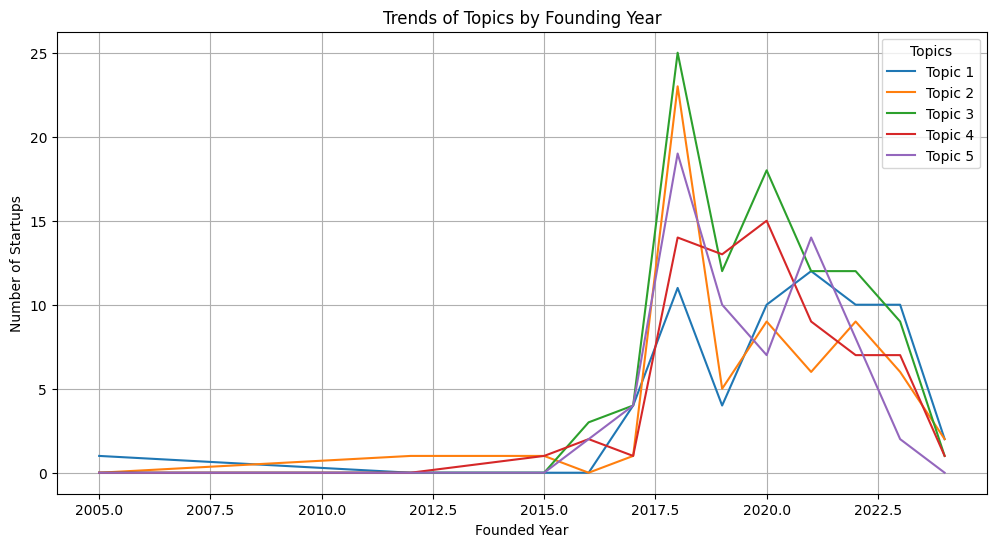

In [19]:
df['Founded'] = pd.to_numeric(df['Founded'], errors='coerce')

# Drop rows without a valid 'Founded' year for this analysis
df_year_filtered = df.dropna(subset=['Founded']).copy()
df_year_filtered['Founded'] = df_year_filtered['Founded'].astype(int)

# Group by founding year and count topic occurrences per year
topic_trends = pd.crosstab(df_year_filtered['Founded'], df_year_filtered['topic'])

# Plot the trends to visualize topic prevalence over the years
plt.figure(figsize=(12, 6))
for topic in topic_trends.columns:
    plt.plot(topic_trends.index, topic_trends[topic], label=f'Topic {topic+1}')

plt.xlabel("Founded Year")
plt.ylabel("Number of Startups")
plt.title("Trends of Topics by Founding Year")
plt.legend(title="Topics")
plt.grid()
plt.show()

##### Sentiment Analysis
Determine the sentiment or tone of each description. VADER (Valence Aware Dictionary for Sentiment Reasoning) to classify each description as positive, negative, or neutral.

In [20]:
# Function to calculate sentiment score
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [21]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis on the "Business Description" column
df['Sentiment'] = df['Business Description'].fillna('').apply(get_sentiment)

# Display sentiment results
sentiment_counts = df['Sentiment'].value_counts()
print("Sentiment Distribution:")
print(sentiment_counts)

Sentiment Distribution:
Sentiment
Positive    308
Neutral      36
Negative     15
Name: count, dtype: int64


**Positive** (≥ 0.05): A compound score above 0.05 is typically considered "positive." This means there is enough positive sentiment to differentiate it from neutral.

**Negative** (≤ -0.05): A compound score below -0.05 is considered "negative," indicating a clear presence of negative sentiment.

**Neutral** (-0.05 to 0.05): Compound scores between -0.05 and 0.05 are classified as "neutral," as they do not show strong enough sentiment to be categorized as positive or negative.

In [22]:
# Filter the dataframe to only include rows where the sentiment is negative
negative_sentiment_df = df[df['Sentiment'] == 'Negative']

print(negative_sentiment_df['Name'].tolist())

['Zeta Diagnostic', 'SoundWheel', 'danBots', 'Novo Nordisk', 'Rodinia Generation', 'Probmet', 'Myco4Food', 'SelfBack', 'Henlez', 'GrowthBond', 'Nature Preserve', 'Lophora', 'InProTher', 'Kontolink', '21RISK']


In [23]:
negatives_business = negative_sentiment_df['Business Description'].tolist()
negatives_business[0:4]

['Eustachian Tube Dysfunction (ETD) is a common middle ear condition, that affects 4-5% of the global population, and as much as 40% of the children below the age of five.',
 'Meditation is notfor everyone!Many people experience restlessness when they try ordinary mindfulness or meditation exercises.',
 'First intraoral scanner for less than DKK 30,000. Introductory price: we pay the VAT!',
 "Novo Nordisk is a leading global healthcare company founded in 1923 and headquartered in Denmark. The company's purpose is to drive change to defeat diabetes and other serious chronic diseases such as obesity, rare blood disorders, and endocrine disord.."]

VADER's sentiment analysis approach often misclassifies certain business descriptions as negative due to inherent connotations of specific terms, despite the positive intent behind them. Medical terminology, such as "Eustachian Tube Dysfunction," "brain metastases," and "treatment-resistant depression," includes negative words that can skew sentiment results, even when companies are focused on providing solutions.

Additionally, phrases addressing industry challenges—such as "overproduction," "financial losses," and "avoidable food waste"—highlight problems that VADER may interpret negatively. Descriptions related to "risk management" or "compliance" often contain terminology associated with potential losses, such as "risk" and "claims," which may further lead to negative sentiment classification.

Furthermore, statements reflecting difficulties in innovation, like "terrible conditions" and "few available therapeutics," convey urgency and hardship that can also be perceived negatively. Comparative phrases intended to emphasize progress, such as "technology invented before the internet," may use words that VADER associates with negative sentiment.


### Graph Analysis

For the video:

1. Data Preparation:

We started with a CSV file containing startup companies and their associated tags (keywords describing their focus).
We created a graph where companies are nodes, and an edge is drawn between two companies if they share at least two tags.

2. Community Detection:

Using the Louvain method, we applied community detection to identify groups of similar companies based on shared tags. These groups represent communities of startups with similar interests.

3. Tag Analysis for Each Community:

For each community, we extracted the most frequent tags and identified the top two tags with the highest occurrences within that community.

4. Article Analysis:

We then extracted the main text of a target article (e.g., from Forbes) using the Newspaper3k library.
We checked whether the top two tags from each community appeared in the article text, helping us understand if these startup interests are relevant to current trends.

5. Final Output:

The result is a dictionary showing which tags from each community are mentioned in the article.

A network was created by making each company a node and connecting them based on shared tags (activities) to provide a more direct view of relationships within the Danish startup ecosystem.


**Creating the Graph**

**Option 1:** Create the network by joining nodes whenever they share a Tag. This yielded unsatisfactory results.

In [24]:
import pandas as pd
import networkx as nx
from itertools import combinations

# Load the CSV file
data = pd.read_csv("/content/drive/MyDrive/SocialGraphsData/danish_startups.csv")

# Initialize an undirected graph
G = nx.Graph()

# Iterate through each company and extract its tags
company_tags = {}
for idx, row in data.iterrows():
    company = row['Name']
    tags = row['Tags']
    tag_list = [tag.strip() for tag in tags.split(',')] if pd.notnull(tags) else []
    company_tags[company] = tag_list
    # Add the company as a node
    G.add_node(company)

# Create edges based on shared tags
for (company1, tags1), (company2, tags2) in combinations(company_tags.items(), 2):
    # Find common tags between the two companies
    shared_tags = set(tags1) & set(tags2)
    if shared_tags:
        # Add an edge with weight equal to the number of shared tags
        G.add_edge(company1, company2, weight=len(shared_tags))

# Save or visualize the graph
nx.write_gexf(G, "danish_startup_graph.gexf")

**Option 2:** We set a criteria to establish when to join two nodes is that they should share more than 1 tag.

In [25]:
from itertools import combinations
from collections import Counter

# Threshold for number of shared tags
tag_threshold = 2

# Create a new graph
G = nx.Graph()

# Add nodes
for company in company_tags.keys():
    G.add_node(company)

# Add edges based on thresholded shared tags
for (company1, tags1), (company2, tags2) in combinations(company_tags.items(), 2):
    shared_tags = set(tags1) & set(tags2)
    if len(shared_tags) >= tag_threshold:
        G.add_edge(company1, company2)


**Option 3:** Weight Edges Based on Tag Similarity. Instead of adding an edge based only on shared tags, you could weight each edge by the number of shared tags.

In [26]:
# Create a new graph
G = nx.Graph()

# Add nodes
for company in company_tags.keys():
    G.add_node(company)

for (company1, tags1), (company2, tags2) in combinations(company_tags.items(), 2):
    shared_tags = set(tags1) & set(tags2)
    if shared_tags:
        G.add_edge(company1, company2, weight=len(shared_tags))

**Option 4:**

In [27]:
import pandas as pd
import re
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


data = pd.read_csv("/content/drive/MyDrive/SocialGraphsData/danish_startups.csv")


# Preprocess tags
def preprocess_tags(tags):
    # Split by common delimiters, lowercase, and remove special characters
    tags = re.split(r'[,\s]+', tags.lower())
    tags = [re.sub(r'[^a-z0-9]', '', tag) for tag in tags if tag]  # Remove special characters
    return ' '.join(tags)

# Apply preprocessing
data['processed_tags'] = data['Tags'].apply(preprocess_tags)

# Vectorize tags using TF-IDF
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(data['processed_tags'])

# Calculate similarity between companies
similarity_matrix = cosine_similarity(tfidf_matrix)

# Define a threshold for considering companies as "related"
threshold = 0.7

# Create the graph
G = nx.Graph()

# Add nodes and edges
for i, company_a in enumerate(data['Name']):
    G.add_node(company_a)  # Add each company as a node
    for j, company_b in enumerate(data['Name']):
        if i != j and similarity_matrix[i, j] >= threshold:
            # If similarity is above threshold, add an edge
            G.add_edge(company_a, company_b, weight=similarity_matrix[i, j])

# Check graph properties (optional)
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Save or plot the graph (optional)
nx.write_gexf(G, '/content/drive/MyDrive/SocialGraphsData/company_similarity_graph.gexf')  # Save for visualization in Gephi or other tools



Number of nodes: 359
Number of edges: 198


**Option 5:** Final

In [28]:
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')

def get_wordnet_synonyms(word):
    synonyms = set()
    for synset in wordnet.synsets(word):
        for lemma in synset.lemmas():
            synonyms.add(lemma.name().replace('_', ' '))
    return synonyms

# Example usage
print(f"Synonyms for 'ai': {get_wordnet_synonyms('biotechonology')}")


[nltk_data] Downloading package wordnet to /root/nltk_data...


Synonyms for 'ai': set()


In [47]:
import pandas as pd
import re
import networkx as nx
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load data
data = pd.read_csv("/content/drive/MyDrive/SocialGraphsData/danish_startups.csv")

# Preprocess tags to lowercase and remove special characters
def preprocess_tags(tags):
    tags = re.split(r'[,\s]+', tags.lower())  # Split on commas and spaces
    tags = [re.sub(r'[^a-z0-9]', '', tag) for tag in tags if tag]  # Remove special characters
    return tags

data['processed_tags'] = data['Tags'].apply(preprocess_tags)

# Load Sentence Transformer model
model = SentenceTransformer('all-mpnet-base-v2')

# Generate embeddings for each unique tag
unique_tags = set(tag for tags in data['processed_tags'] for tag in tags)
tag_embeddings = {tag: model.encode(tag) for tag in unique_tags}

# Compute a single vector embedding for each company by averaging their tag embeddings
def get_company_embedding(tags):
    embeddings = [tag_embeddings[tag] for tag in tags if tag in tag_embeddings]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.get_sentence_embedding_dimension())  # Fallback if no tags

data['company_embedding'] = data['processed_tags'].apply(get_company_embedding)

# Build the graph using cosine similarity between company embeddings
G = nx.Graph()

# Add nodes for each company
for company in data['Name']:
    G.add_node(company)

# Set a cosine similarity threshold for connecting companies
similarity_threshold = 0.80 # Adjust based on desired connectivity

# Calculate similarity between each pair of companies
for i, company_a in enumerate(data['Name']):
    embedding_a = data['company_embedding'].iloc[i]
    for j, company_b in enumerate(data['Name']):
        if i >= j:
            continue  # Avoid double counting and self-comparison
        embedding_b = data['company_embedding'].iloc[j]

        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_a], [embedding_b])[0][0]

        # Add an edge if similarity is above threshold
        if similarity >= similarity_threshold:
            G.add_edge(company_a, company_b, weight=similarity)

# Check graph properties (optional)
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Optionally, save the graph for visualization
nx.write_gexf(G, "/content/drive/MyDrive/SocialGraphsData/company_similarity_graph_cosine.gexf")


Number of nodes: 359
Number of edges: 1576


##### Community Detection with Louvain

In [30]:
!pip install python-louvain

In [48]:
# Perform community detection
partition = community_louvain.best_partition(G)

# Add the community information as a node attribute for visualization
for company, community_id in partition.items():
    G.nodes[company]['community'] = community_id


In [49]:
# Betweenness centrality: how often a node appears on shortest paths between other nodes
betweenness_centrality = nx.betweenness_centrality(G)

# Degree centrality: number of direct connections to each node
degree_centrality = nx.degree_centrality(G)

# Add centrality as a node attribute for easier access in visualization
nx.set_node_attributes(G, betweenness_centrality, 'betweenness')
nx.set_node_attributes(G, degree_centrality, 'degree')


In [33]:
print(f"Betweenness centrality: {betweenness_centrality}")
print(f"Degree centrality: {degree_centrality}")

Betweenness centrality: {'Print Pronto': 0.0, 'Ocean.io': 0.0028425618287187624, 'Fluentos': 0.004353415241222884, 'EagleHunt AI': 0.0, 'Machina Sports': 0.0, 'Wallpapery': 0.0, 'Strongsize': 0.0, 'Minibook': 0.0, 'Zeta Diagnostic': 0.0, 'Wenemea': 0.0, 'Umamamia': 0.0, 'The 0-Mission': 0.0, 'Suplient': 0.003977265842046577, 'SoundWheel': 0.0, 'Skypuzzler': 0.0, 'Sens-vue': 0.0, 'ROICO': 0.0, 'QASE Tech': 0.0, 'Phlit': 0.0, 'Økoskabet': 0.0, 'Oceanswell Energy': 0.0, 'NordInvent': 0.0, 'HubBroker ApS': 0.0, 'NeoCare Nordic': 0.0, 'næctar': 0.0028425618287187624, 'Mixtery': 0.0, 'Leaf Insurance': 0.0, 'Insutex': 0.0, 'GET LIT DK': 0.0, 'EXO360': 0.0, 'Exitplanner': 0.016944588743353764, 'Ergasta': 0.0, 'Pattrnz': 0.0, 'Clair Scientific': 0.0, 'Bygaard': 0.0, 'Bikekey': 0.0, 'BeWo': 0.0, 'Wecycle Furniture': 0.0, 'Vocaire': 0.010735455718164522, 'Unmute Greetings': 0.0, 'TuneButler': 0.0, 'Tinyfarms': 0.0, 'SyncDesk': 0.0028425618287187624, 'SWÖM': 0.0, 'Sustainly': 0.0, 'SPEDA': 0.01155

##### Visualization

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

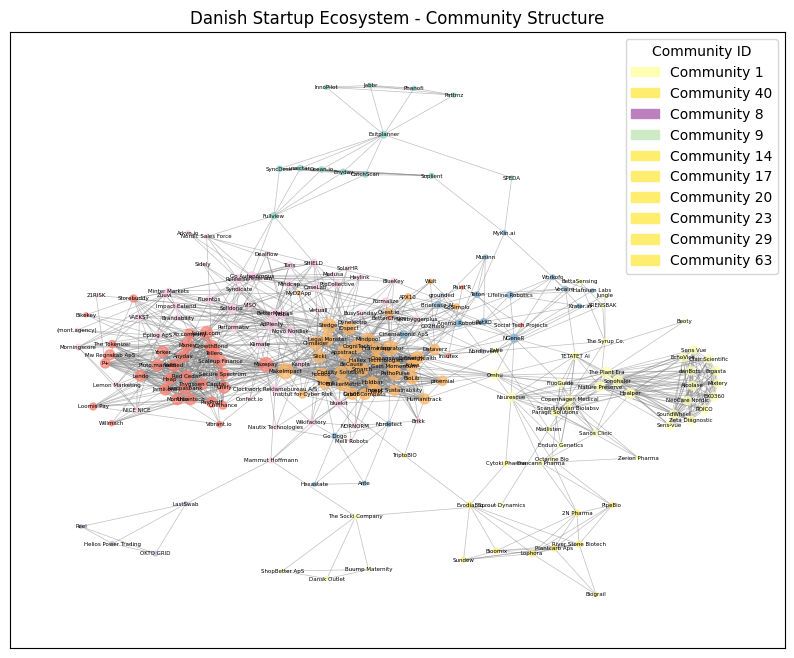

In [53]:
# Filter out nodes with degree less than a threshold (e.g., 2)
filtered_nodes = [node for node, degree in dict(G.degree()).items() if degree > 2]
H = G.subgraph(filtered_nodes)  # Subgraph with only nodes of interest

# Re-visualize with only this subgraph
pos = nx.kamada_kawai_layout(H)

# Set node color based on community and node size based on degree centrality
node_color = [partition[node] for node in H.nodes()]
# Scale node sizes and edge widths for better distinction
node_size = [800 * degree_centrality[node] for node in H.nodes()]

plt.figure(figsize=(10, 8))

# Draw the graph with color-coded communities
nx.draw_networkx_nodes(H, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.Set3, alpha=0.7)
nx.draw_networkx_edges(H, pos, width=0.5, alpha=0.5, edge_color="gray")
nx.draw_networkx_labels(H, pos, font_size=4, font_family="sans-serif")

# Create a legend based on the unique community IDs
unique_communities = set(node_color)
legend_handles = [mpatches.Patch(color=plt.cm.Set3(i / len(unique_communities)), label=f'Community {i}')
                  for i in unique_communities]

# Add legend to the plot
plt.legend(handles=legend_handles, title="Community ID", loc="best")
plt.title("Danish Startup Ecosystem - Community Structure")
from google.colab import files
plt.savefig("graph.pdf")
files.download("graph.pdf")
plt.show()





See the centrality measures

<ipython-input-35-66c254769011>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(top_betweenness_companies, rotation=45, ha="right")
<ipython-input-35-66c254769011>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(top_degree_companies, rotation=45, ha="right")


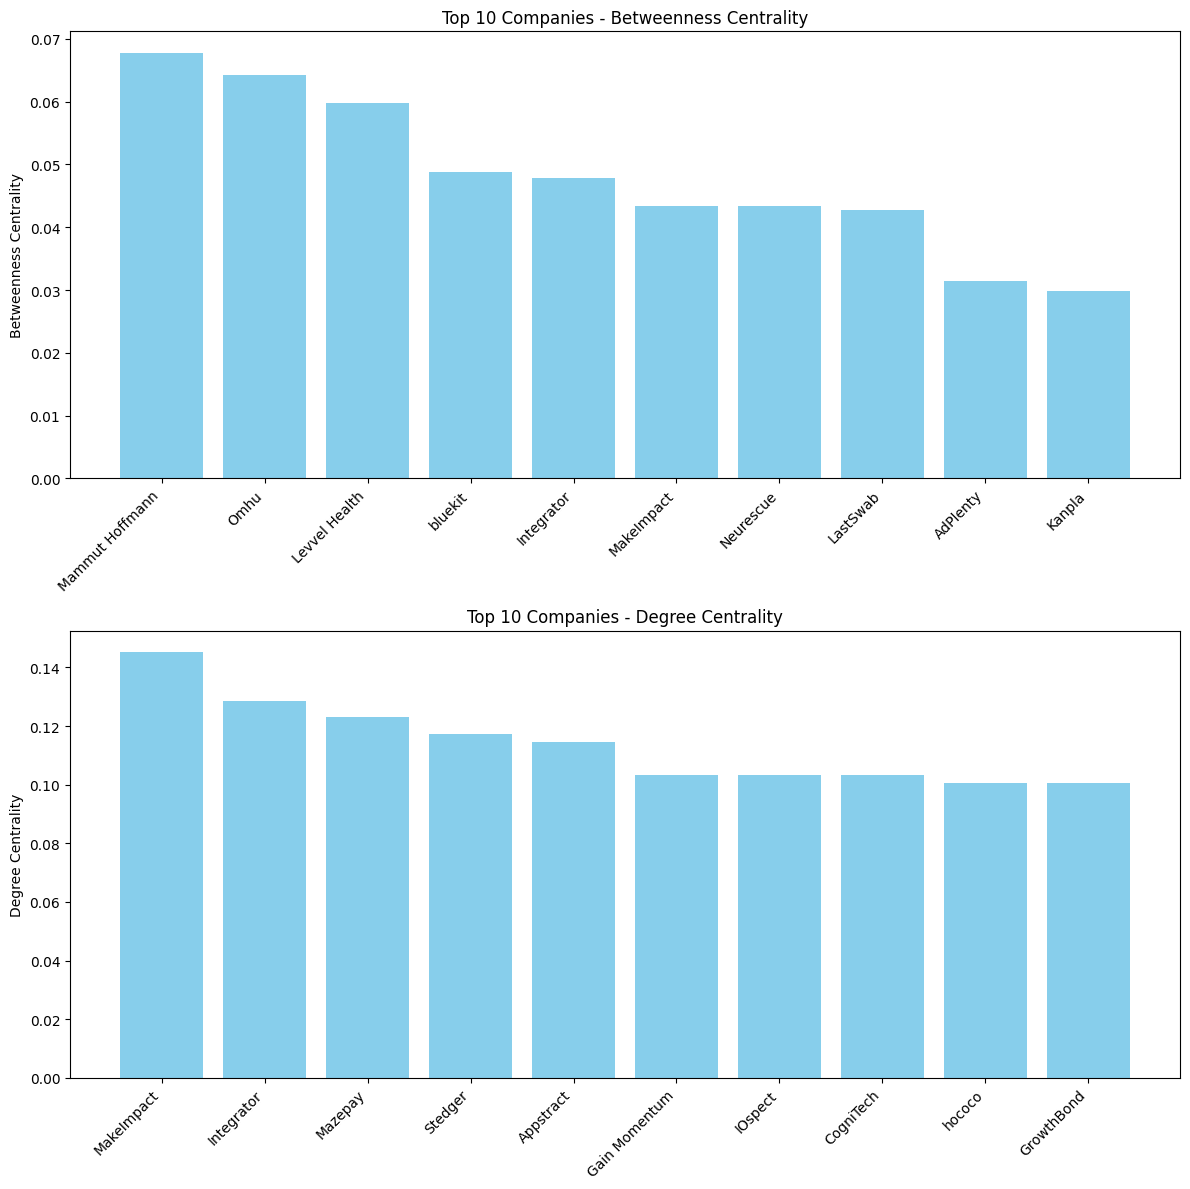

In [35]:
# Sort the dictionaries by centrality score (descending)
sorted_betweenness = dict(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))
sorted_degree = dict(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))

# Limit to top 10 companies for both centralities
top_betweenness_companies = list(sorted_betweenness.keys())[:10]
top_betweenness_scores = list(sorted_betweenness.values())[:10]

top_degree_companies = list(sorted_degree.keys())[:10]
top_degree_scores = list(sorted_degree.values())[:10]

# Set up the figure with two subplots (nrows=2, 1 column)
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 12))

# Bar plot for Betweenness Centrality
ax1.bar(top_betweenness_companies, top_betweenness_scores, color="skyblue")
ax1.set_title("Top 10 Companies - Betweenness Centrality")
ax1.set_ylabel("Betweenness Centrality")
ax1.set_xticklabels(top_betweenness_companies, rotation=45, ha="right")

# Bar plot for Degree Centrality
ax2.bar(top_degree_companies, top_degree_scores, color="skyblue")
ax2.set_title("Top 10 Companies - Degree Centrality")
ax2.set_ylabel("Degree Centrality")
ax2.set_xticklabels(top_degree_companies, rotation=45, ha="right")

# Adjust layout to avoid overlap
plt.tight_layout()

# Show plot
plt.show()
plt.show()

Modularity: 0.6234448765240458


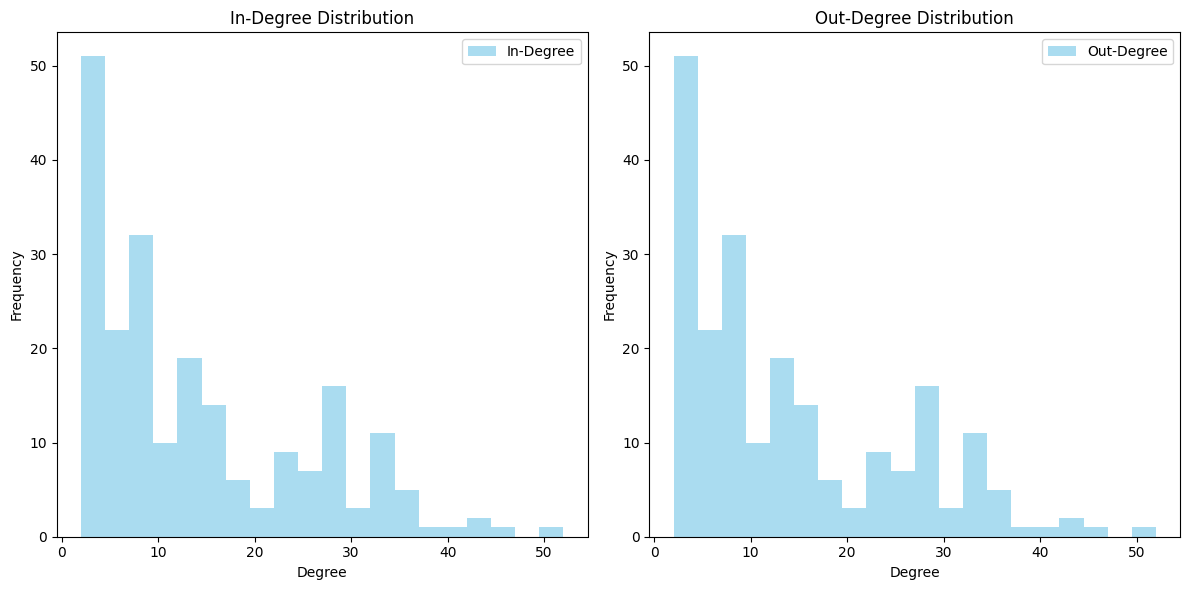

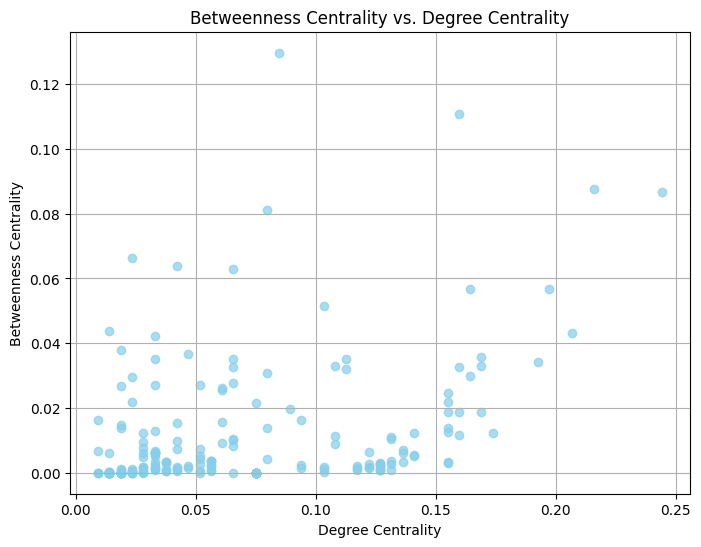

Assortativity Coefficient: 0.4701352104936605


In [54]:

# Compute centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
in_degree = dict(G.in_degree() if G.is_directed() else G.degree())
out_degree = dict(G.out_degree() if G.is_directed() else G.degree())

# Plot modularity (already computed if partition available)
import community.community_louvain as community_louvain

mod_score = community_louvain.modularity(partition,H)
print(f"Modularity: {mod_score}")

# **1. Degree Distributions**
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(in_degree.values(), bins=20, color="skyblue", alpha=0.7, label="In-Degree")
plt.title("In-Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(out_degree.values(), bins=20, color="skyblue", alpha=0.7, label="Out-Degree")
plt.title("Out-Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

# **2. Betweenness vs. Degree Centrality**
plt.figure(figsize=(8, 6))
degrees = [degree_centrality[node] for node in G.nodes()]
betweenness = [betweenness_centrality[node] for node in G.nodes()]
plt.scatter(degrees, betweenness, alpha=0.7, color="skyblue")
plt.title("Betweenness Centrality vs. Degree Centrality")
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.grid(True)
plt.show()

# **3. Assortativity**
assortativity_coefficient = nx.degree_assortativity_coefficient(G)
print(f"Assortativity Coefficient: {assortativity_coefficient}")

See the distribution of tags for each community


In [37]:
# Ensure tags are in the correct format (assuming they are already lists)
data['Tags'] = data['Tags'].apply(lambda x: x if isinstance(x, list) else x.split(', '))

# Create a dictionary from DataFrame for easy lookup
tags_data = dict(zip(data['Name'], data['Tags']))

# Assume 'partition' is already defined, as it contains the community of each node
# Create a DataFrame to store tags and communities for each node
nodes_data = [(node, partition[node], tags_data[node]) for node in G.nodes if node in tags_data]
df = pd.DataFrame(nodes_data, columns=['Name', 'Community', 'Tags'])

# Filter communities with more than 5 nodes
community_counts = df['Community'].value_counts()
large_communities = community_counts[community_counts > 5].index
df_large = df[df['Community'].isin(large_communities)]

# Calculate tag frequency for each community
for community in large_communities:
    community_df = df_large[df_large['Community'] == community]

    # Flatten all tags within this community and count frequencies
    tags = [tag for tags_list in community_df['Tags'] for tag in tags_list]
    tag_counts = Counter(tags)
    print(tag_counts)

    # Plot the frequency distribution of tags for this community
    #plt.figure(figsize=(12, 8))
    #plt.bar(tag_counts.keys(), tag_counts.values())
    #plt.title(f"Tag Frequency Distribution in Community {community}")
    #plt.xlabel("Tags")
    #plt.ylabel("Frequency")
    #plt.xticks(rotation=90, ha='right')
    #plt.tight_layout()
    #plt.show()

Counter({'SaaS': 14, 'Software': 14, 'B2B': 8, 'E-Commerce': 5, 'Advertising': 5, 'Marketing': 4, 'Analytics': 4, 'marketing': 3, 'Internet Publishing': 3, 'Product Design': 3, 'Consulting': 3, 'Apps': 3, 'Real Estate': 3, 'Project Management': 3, 'Digital Marketing': 3, 'Internet': 3, 'SEO': 3, 'Business': 2, 'Software Development': 2, 'Fashion': 2, 'advertising': 2, 'Marketplace': 2, 'Information Technology': 2, 'Product Management': 2, 'Logistics': 2, 'Insurance': 2, 'InsurTech': 2, 'Enterprise Applications': 2, 'Food Delivery': 2, '3D Technology': 2, 'Service Industry': 2, 'Platform': 2, 'Advertising Services': 2, 'Risk Management': 2, 'IT Services': 2, 'platform': 2, 'Marketing Platform': 1, 'Popup': 1, 'Conversion Rate Optimization': 1, 'Godaddy Nameserver,Marketing Automation,Image and Video Services,': 1, 'Marketing Automation,Email Hosting Service,Tag Management,': 1, 'Customer Support,Email Delivery Service,Cloud Computing Services': 1, 'Tag Management,Godaddy Nameserver,Mark

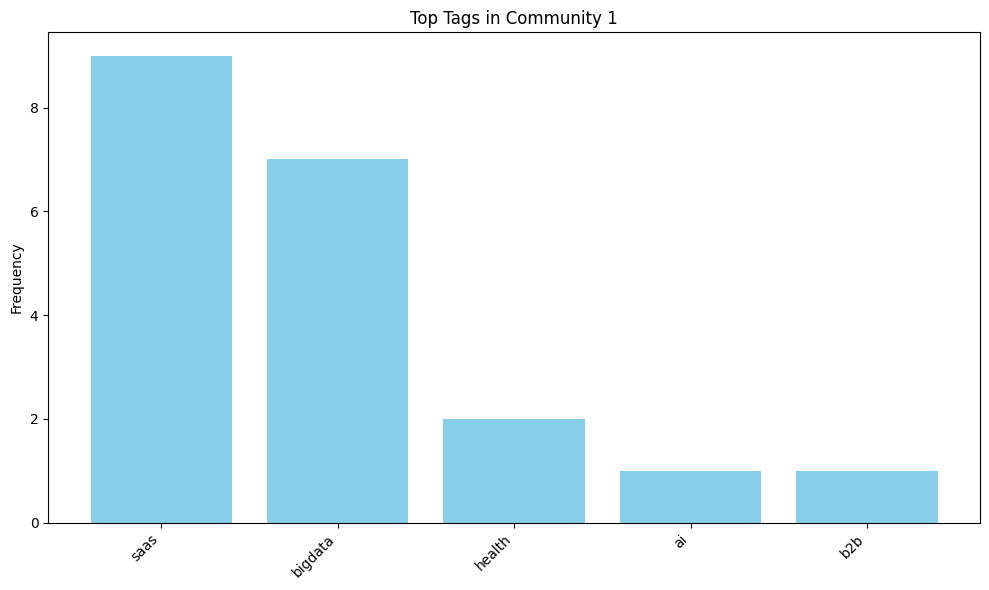

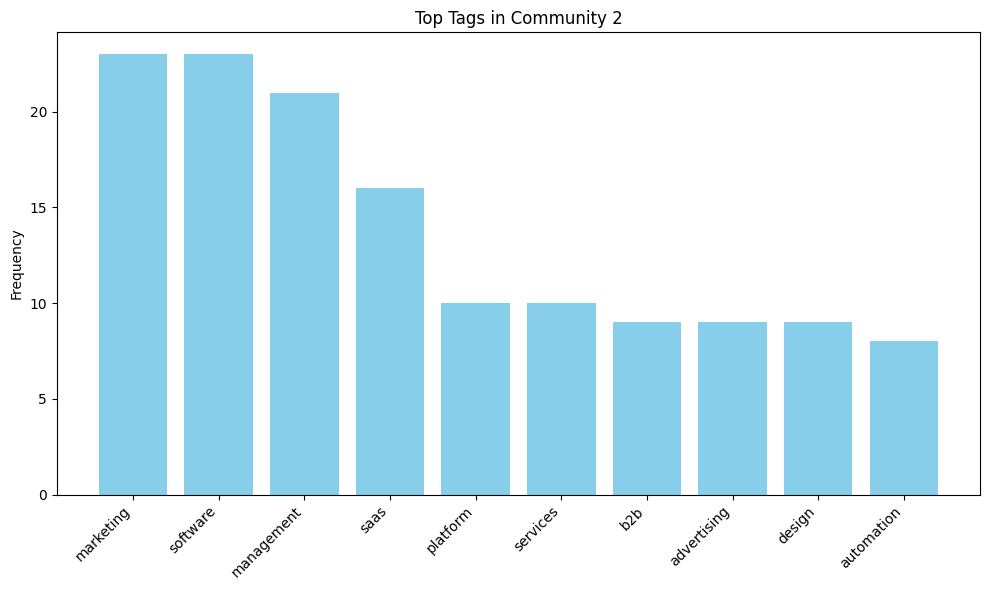

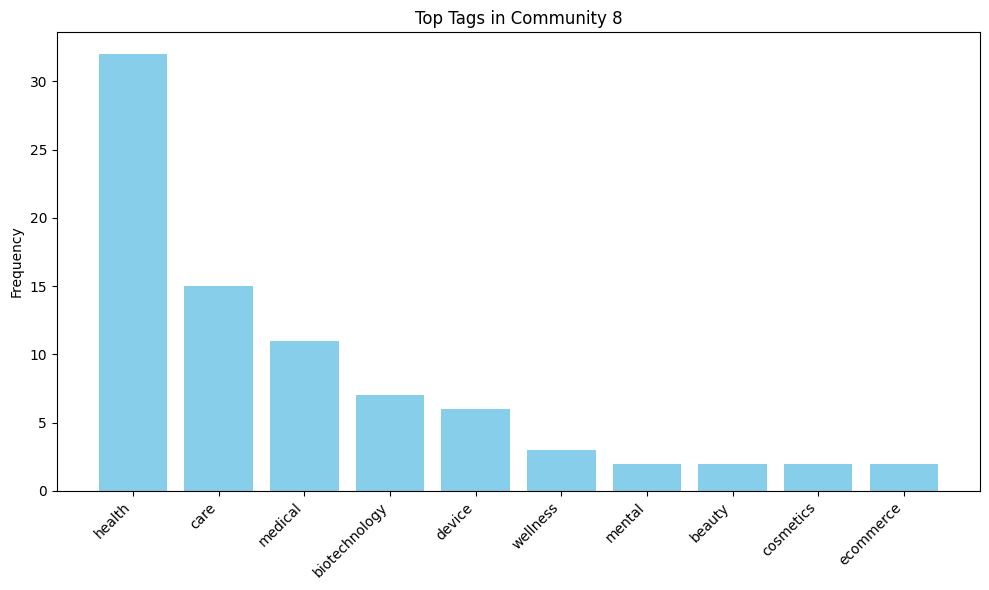

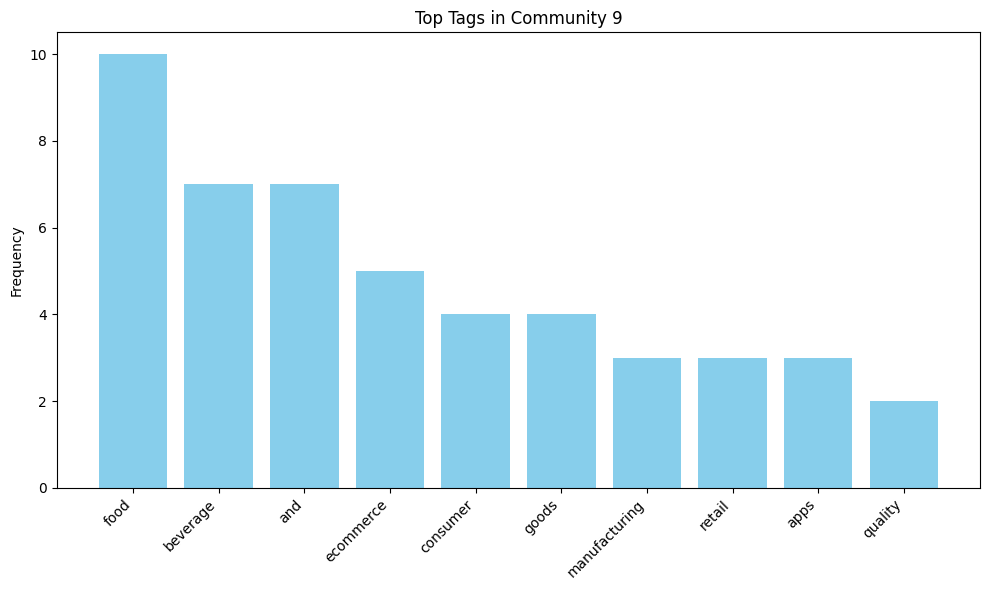

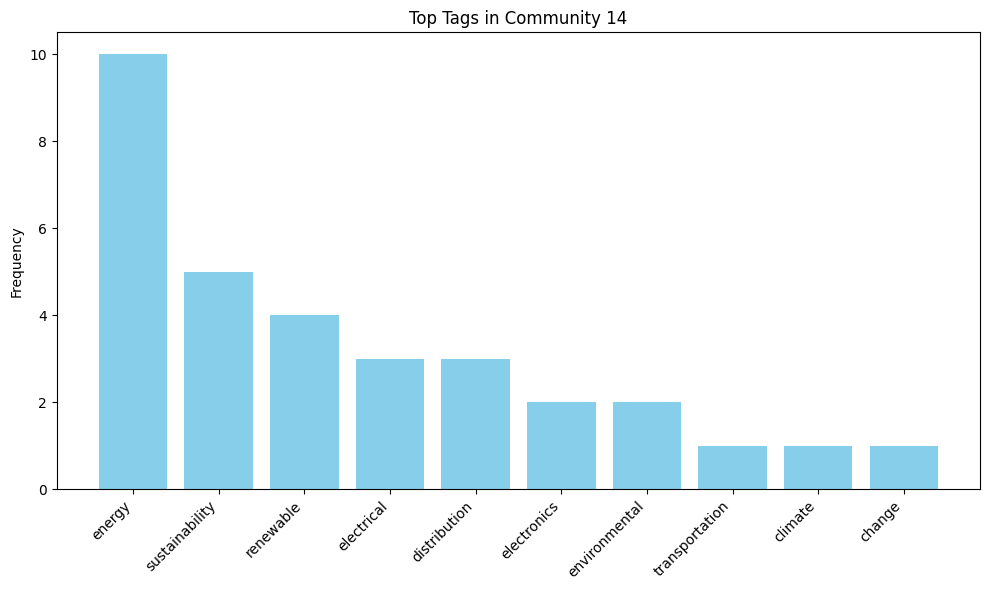

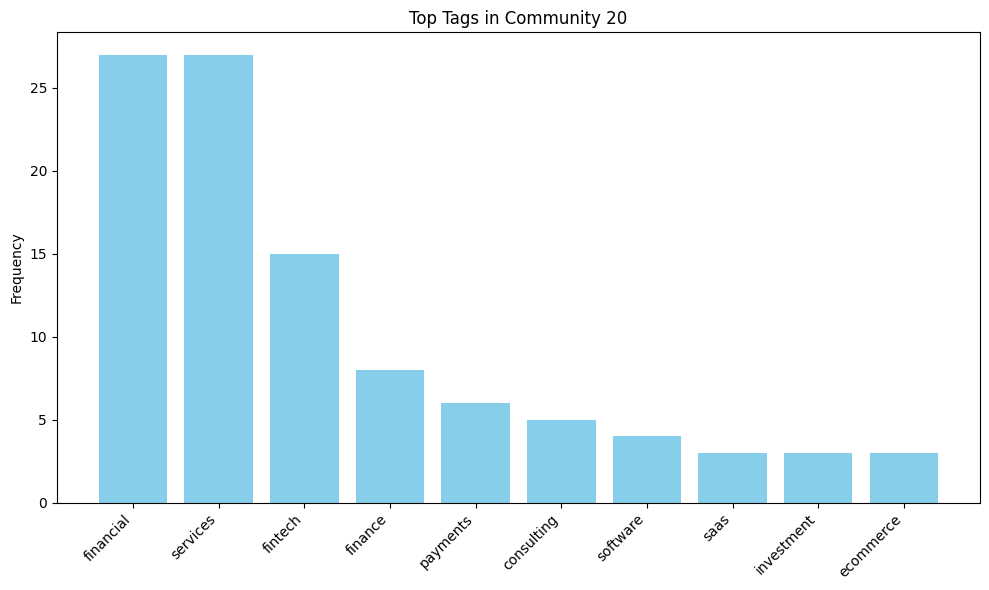

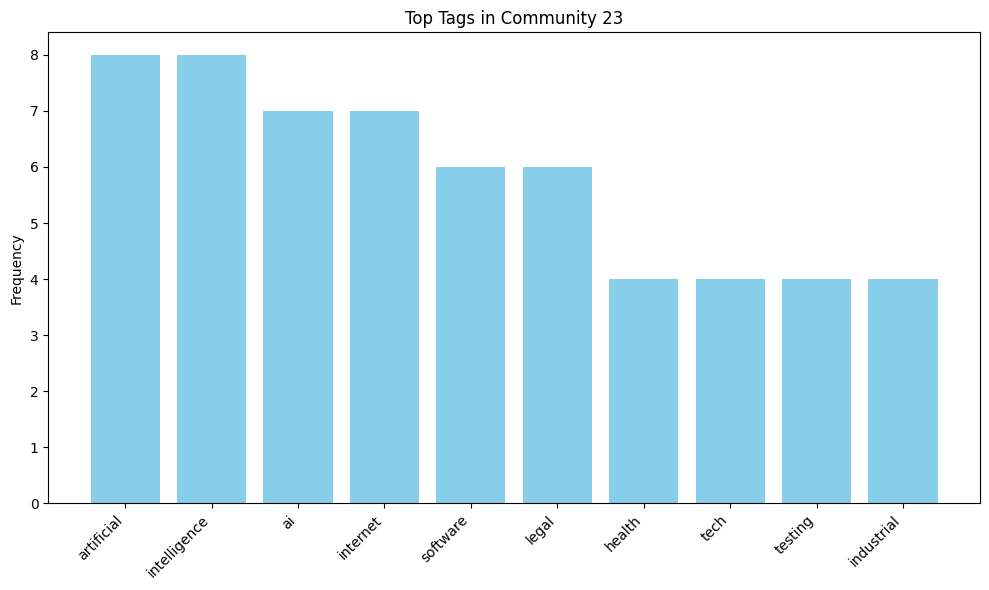

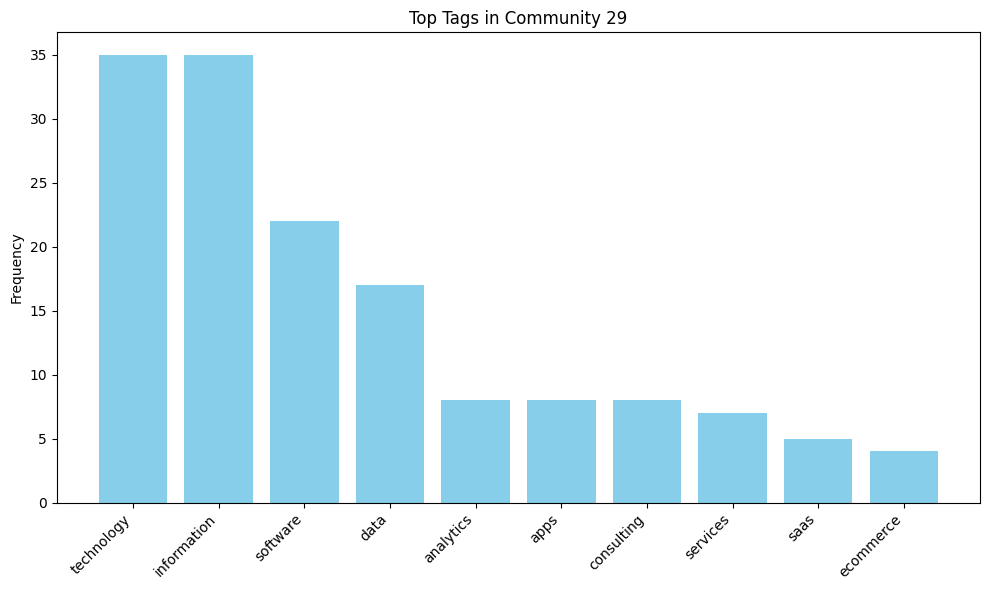

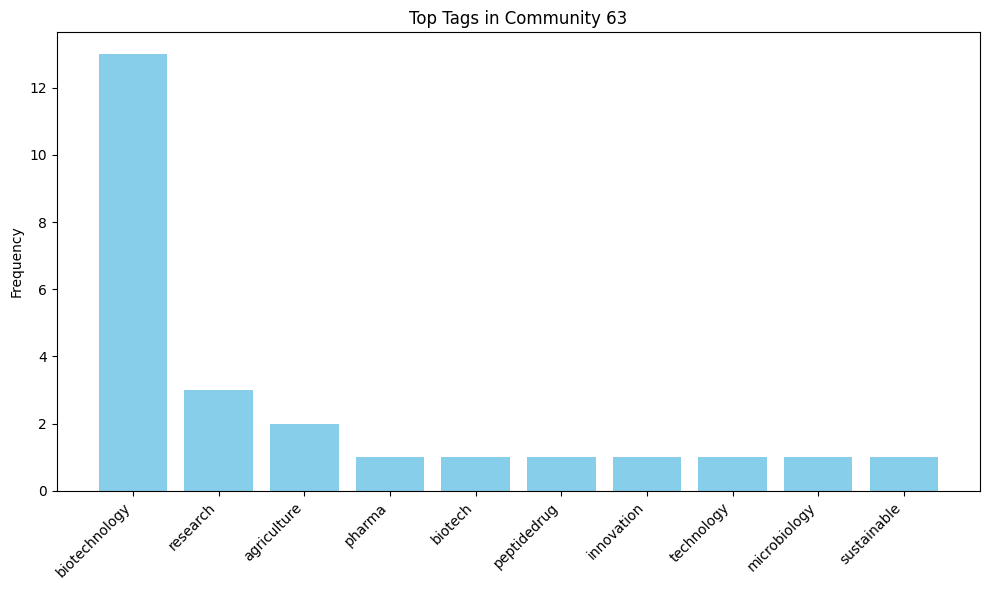

In [38]:
import matplotlib.pyplot as plt
from collections import Counter

# Ensure that each company has its community mapped correctly
data['Community'] = data['Name'].map(partition)  # Map community IDs to each company
tags_per_community = data.groupby('Community')['processed_tags'].sum()  # Aggregate tags by community

# Plot top tags for communities with more than 5 members
for community, tags in tags_per_community.items():
    # Check if community size is greater than 5
    if data[data['Community'] == community].shape[0] > 5:
        tag_counts = Counter(tags)
        top_tags = dict(tag_counts.most_common(10))  # Get top 10 tags

        plt.figure(figsize=(10, 6))
        plt.bar(top_tags.keys(), top_tags.values(), color='skyblue')
        plt.title(f"Top Tags in Community {community}")
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()


<ipython-input-39-11c1f6f806e6>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-39-11c1f6f806e6>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-39-11c1f6f806e6>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-39-11c1f6f806e6>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


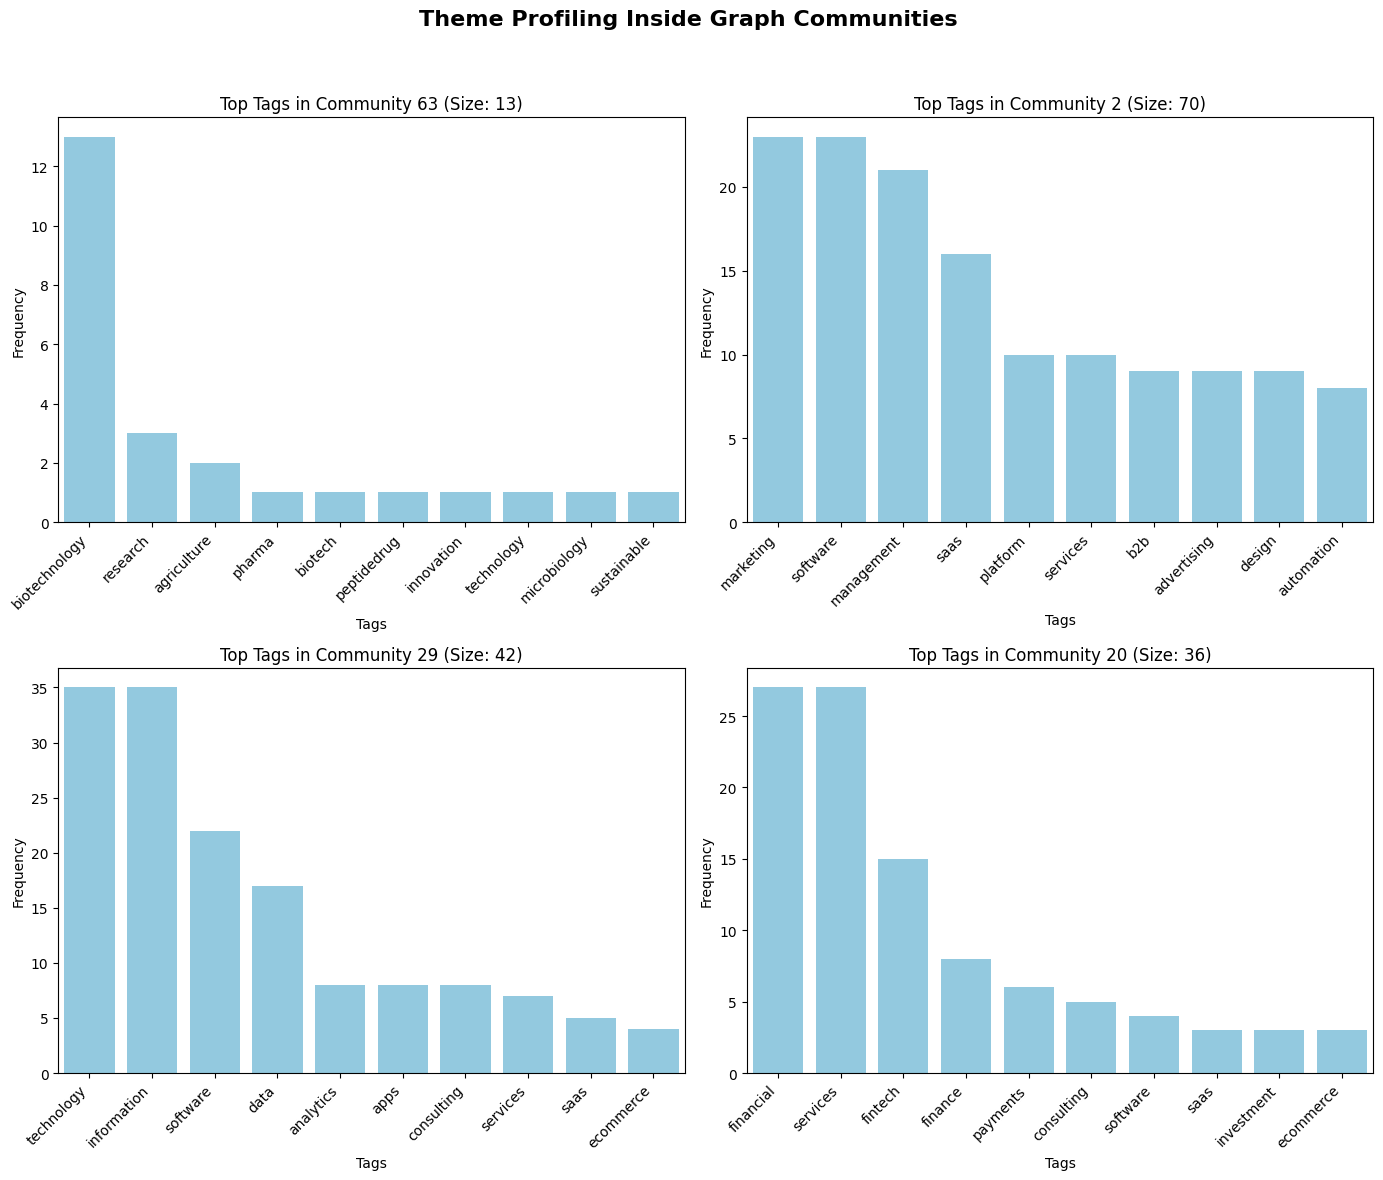

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random

# Setting a color palette

# Filter communities larger than 5 nodes and get random 4 communities
large_communities = {k: v for k, v in data['Community'].value_counts().items() if v > 5}
random_communities = random.sample(list(large_communities.keys()), 4)

# Initialize subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()  # Flatten for easy iteration

# Loop over each community and plot the top tags
for i, community in enumerate(random_communities):
    # Aggregate and count tags for the community
    tags = data[data['Community'] == community]['processed_tags'].sum()
    tag_counts = Counter(tags)
    top_tags = dict(tag_counts.most_common(10))

    # Bar plot for top tags in this community
    ax = axes[i]
    sns.barplot(x=list(top_tags.keys()), y=list(top_tags.values()), ax=ax, color='skyblue')
    ax.set_title(f"Top Tags in Community {community} (Size: {large_communities[community]})")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Tags")

# Add a big title to the figure
fig.suptitle("Theme Profiling Inside Graph Communities", fontsize=16, fontweight='bold')

# Adjust layout and display
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
plt.show()


##### Second iteration of applying Natural Language Processing
**Calculating Scores Based on External Texts like Forbes magazine top 5 startup topics for 2025.**


- Step 1: Gather content from articles, blog posts, or reports related to startups. (Experiment for 1 article)


- Step 2: Create a tag scoring function that calculates the occurrence frequency of each tag (or its category) within the text data. This score can represent how prominently a tag (or category) appears in startup-related discussions.

Articles used for this experiment:

https://www.forbes.com/sites/bernardmarr/2024/09/30/the-5-biggest-business-trends-for-2025-everyone-must-be-ready-for-now/

https://www.forbes.com/sites/melissahouston/2024/10/18/5-profitable-business-ideas-in-demand-for-2025/

**Step 1**

In [40]:
# Function to extract the main text from an article URL with custom headers
def extract_article_text(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }

    # Make the request with custom headers to bypass the 403 error
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        # If successful, use newspaper3k to parse the article
        article = Article(url)
        article.set_html(response.text)  # Set the raw HTML content
        article.parse()  # Parse the HTML content
        return article.text  # Return the main text of the article
    else:
        print(f"Failed to retrieve the article. Status code: {response.status_code}")
        return None

url = "https://www.forbes.com/sites/melissahouston/2024/10/18/5-profitable-business-ideas-in-demand-for-2025/"  # Replace with the URL of the article
main_text = extract_article_text(url)

if main_text:
    print(main_text)

5 Profitable Businesses In Demand For 2025 getty

Entrepreneurs are always on the lookout for profitable opportunities. With shifts in technology, consumer behavior, and global needs, 2025 presents a variety of high-demand industries ripe for those ready to start or grow a business.

These five business ideas are ideal for profitability:

1. Healthcare Services for Seniors

With an aging population and the increasing demand for senior care, businesses that provide healthcare services for seniors are not just profitable but essential. The global senior care industry is expected to grow exponentially as baby boomers age. Services such as home healthcare, assisted living facilities, and specialized senior care centers are in high demand.

Why it's profitable:

Many seniors want to stay at home for as long as they can, and that creates opportunities for home care services. Offering specialized care, such as dementia care, allows entrepreneurs to serve a niche with specific needs.

How to g

**Step 2**

- Identify the Communities and Their Tags: For each community, the tags were extracted and associated with it.

- Get the Two Most Frequent Tags: For each community, identify the top two most frequent tags based on their frequency of occurrence.

- Extract the Article's Main Text: Extract the article information.

- Check if Tags Appear in the Text: For each of the most frequent tags in a community, check if they appear in the article's main text and if so, retrieve them.

In [41]:
def extract_article_text(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        article = Article(url)
        article.set_html(response.text)  # Set the raw HTML content
        article.parse()  # Parse the HTML content
        return article.text
    else:
        print(f"Failed to retrieve the article. Status code: {response.status_code}")
        return None

# Function to get the top 2 most frequent tags for each community
def get_top_tags_for_community(tags_list):
    tag_counter = Counter(tags_list)
    top_tags = tag_counter.most_common(2)
    return [tag[0] for tag in top_tags]

# Function to check if tags appear in the article text and return only true tags
def check_tags_in_article(url, communities_data):
    main_text = extract_article_text(url)
    if main_text is None:
        return None

    cleaned_text = main_text.lower()
    results = {}

    for community, data in communities_data.items():
        # Flatten the list of tags for the companies in this community
        tags = [tag for sublist in data for tag in sublist]  # Flatten the list of tags for the community
        top_tags = get_top_tags_for_community(tags)

        # Check if each top tag appears in the article text, keeping only true tags
        true_tags = {tag: True for tag in top_tags if re.search(r'\b' + re.escape(tag) + r'\b', cleaned_text)}
        if true_tags:
            results[community] = true_tags

    return results

In [42]:
# Load the CSV file with tags data
data = pd.read_csv("/content/drive/MyDrive/SocialGraphsData/danish_startups.csv")

# Create a dictionary of company names and their associated tags
tags_data = {row['Name']: row['Tags'].split(',') for _, row in data.iterrows()}

# Initialize an undirected graph
G = nx.Graph()

# Add nodes for each company
for company in tags_data.keys():
    G.add_node(company)

# Add edges based on the threshold of shared tags
tag_threshold = 2
for (company1, tags1), (company2, tags2) in combinations(tags_data.items(), 2):
    shared_tags = set(tags1) & set(tags2)
    if len(shared_tags) >= tag_threshold:
        G.add_edge(company1, company2)

# Perform community detection using Louvain method
partition = community_louvain.best_partition(G)

communities_data = {}
for company, community_id in partition.items():
    if community_id not in communities_data:
        communities_data[community_id] = []
    communities_data[community_id].append(tags_data[company])

In this section the team selected articles from the Forbes magazine. There are variouus topics within the articles: small business, business,  innovation, billionaires, life style, investment etc.

In [43]:
# List of article URLs to process
article_urls = [
    "https://www.forbes.com/sites/melissahouston/2024/10/18/5-profitable-business-ideas-in-demand-for-2025/",
    "https://www.forbes.com/sites/bernardmarr/2024/09/30/the-5-biggest-business-trends-for-2025-everyone-must-be-ready-for-now/",
    "https://www.forbes.com/sites/bernardmarr/2024/10/30/the-10-most-powerful-data-trends-that-will-transform-business-in-2025/",
    "https://www.forbes.com/sites/bernardmarr/2024/10/29/the-future-of-retail-10-game-changing-trends-that-will-define-2025/",
    "https://www.forbes.com/councils/forbestechcouncil/2024/11/07/how-tech-can-support-the-voluntary-carbon-market/",
    "https://www.forbes.com/sites/brucejapsen/2024/11/07/oscar-healths-obamacare-business-continues-to-grow-as-trumps-return-looms/",
    "https://www.forbes.com/sites/iainmartin/2024/11/01/saudi-wants-to-use-its-oil-billions-to-become-an-ai-power-player/",
    "https://www.forbes.com/sites/rogersands/2024/11/07/fiji-positions-itself-to-become-the-ultimate-destination-wedding-venue/",
    "https://www.forbes.com/sites/elizabethkarmel/2024/11/07/french-lentil-salad-is-the-side-dish-that-goes-with-everything/",
    "https://www.forbes.com/sites/amyfeldman/2024/10/16/amazon-is-betting-big-on-small-nuclear-reactors-to-power-its-data-centers/",
    "https://www.forbes.com/sites/charliefink/2024/11/07/mawari-raises-108-million-to-launch-tokenized-spatial-streaming-network/",
    "https://www.forbes.com/sites/daveywinder/2024/11/07/cyber-attack-warning-as-hackers-use-ai-and-gmail-in-new-campaign/",
    "https://www.forbes.com/sites/mikestubbs/2024/11/07/new-dota-2-hero-kez-and-crownfall-act-4-launches-later-today/",
    "https://www.forbes.com/sites/brianmazique/2024/11/07/ps5-pro-playstation-games-with-enhancements-on-day-1/",
    "https://www.forbes.com/sites/javierpaz/2024/10/31/did-digital-currency-group-profit-from-60-million-in-north-korean-crypto-money-laundering/",
    "https://www.forbes.com/sites/brendanahern/2024/09/12/china-market-update-alibaba-tencent--meituan-are-buying-their-stock-are-you/",
    "https://www.forbes.com/sites/neilwinton/2024/09/10/will-volkswagen-restructuring-plan-founder-again-on-union-power/",
    "https://www.forbes.com/sites/joemoglia/2024/09/05/could-fantasy-football-be-good-for-your-team-at-work/?ss=ceo-network",
    "https://www.forbes.com/sites/bruceweinstein/2024/10/15/how-do-you-make-ethical-decisions-15-leaders-reveal-their-approaches/?ss=ceo-network",
    "https://www.forbes.com/sites/julianhayesii/2024/09/19/ceo-tenure-success-4-habits-to-thrive-in-a-high-pressure-world/?ss=ceo-network",
]


all_results = {}

for url in article_urls:
    # Get the tags that appear in the article
    article_results = check_tags_in_article(url, communities_data)

    # Remove any instances of the word 'have' from the article results
    filtered_article_results = {
        community: {tag: match for tag, match in tags.items() if tag != "have"}
        for community, tags in article_results.items()
    }

    # Filter out communities with no true tags after removing 'have'
    filtered_article_results = {k: v for k, v in filtered_article_results.items() if v}

    # Save only URLs with at least one matching tag
    if filtered_article_results:
        all_results[url] = filtered_article_results

# Print the final dictionary with URLs and true tags
all_results

{'https://www.forbes.com/sites/melissahouston/2024/10/18/5-profitable-business-ideas-in-demand-for-2025/': {7: {' ai': True},
  68: {'': True},
  85: {'sustainability': True},
  97: {'advertising': True, ' marketing': True},
  106: {'healthcare': True},
  110: {' marketing ': True},
  119: {'sustainability': True, ' marketing': True},
  120: {' portfolio': True},
  155: {' content marketing': True},
  156: {'marketing': True},
  160: {'renewable energy': True}},
 'https://www.forbes.com/sites/bernardmarr/2024/09/30/the-5-biggest-business-trends-for-2025-everyone-must-be-ready-for-now/': {7: {' ai': True},
  68: {'': True},
  85: {'sustainability': True},
  97: {'advertising': True, ' marketing': True},
  106: {'healthcare': True},
  110: {' marketing ': True},
  119: {'sustainability': True, ' marketing': True},
  156: {'marketing': True}},
 'https://www.forbes.com/sites/bernardmarr/2024/10/30/the-10-most-powerful-data-trends-that-will-transform-business-in-2025/': {7: {' ai': True},
 

**Visualization fo the results**

Word cloud plot to visualize the results from the merge of NLP and Graph theory

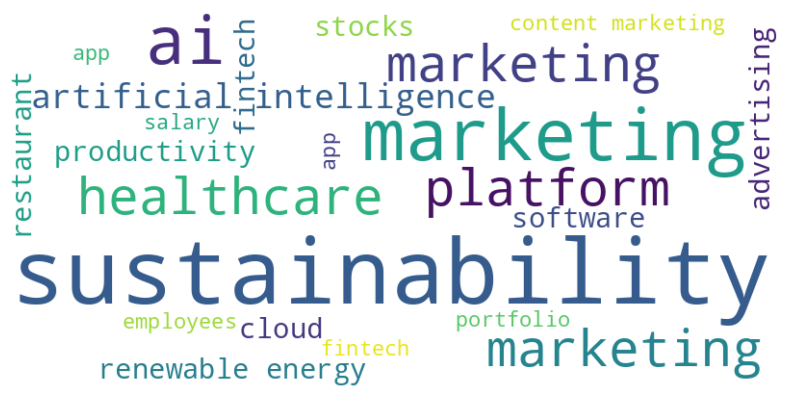

In [44]:
all_tags = []
for url, communities in all_results.items():
    for community, tags in communities.items():
        all_tags.extend(tags.keys())

# Count frequencies of each tag
tag_counts = Counter(all_tags)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_counts)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()